<a href="https://colab.research.google.com/github/dikshank/Human-Pose-Estimation/blob/main/Human_Pose_Estimation(Dikshank).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
from PIL import UnidentifiedImageError
from scipy.ndimage import gaussian_filter
from PIL import Image
import os
from keras.layers import Conv2D,Conv2DTranspose,BatchNormalization
from keras.applications import resnet_v2
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import ReLU
from keras.layers import Reshape
from keras.initializers import random_normal
import tensorflow as tf
import keras


# why are we using pretrained resnet?
# what is likelihood overlapping?

# downloading the dataset

In [ ]:
# ! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2022-01-30 01:22:30--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.201.145
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.201.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  50.4MB/s    in 4.9s    

2022-01-30 01:22:35 (48.7 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
# ! mkdir 'Human Pose Estimation Data'

In [ ]:
# ls

 annotations_trainval2017.zip  'Human Pose Estimation Data'/


In [ ]:
# cd /content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data

/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data


In [ ]:
# ! unzip /content/drive/MyDrive/'Human Pose Estimation'/annotations_trainval2017.zip

Archive:  /content/drive/MyDrive/Human Pose Estimation/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [ ]:
jason_annotations_path = '/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/annotations/person_keypoints_train2017.json'

In [ ]:
file_handle = open(jason_annotations_path)

In [ ]:
file_handle

<_io.TextIOWrapper name='/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/annotations/person_keypoints_train2017.json' mode='r' encoding='UTF-8'>

In [ ]:
jason_annotations = json.load(file_handle)  #this is a dictionary data and each key of this dictionary contains list of information for every image

In [ ]:
# jason_annotations['annotations']

In [ ]:
# jason_annotations['images']

In [ ]:
# jason_annotations["annotations"][0]["keypoints"]

In [ ]:
def compile_examples(json_annotations):

  file_handle = open(json_annotations)
  annotations = json.load(file_handle)

  image_urls = list()

  for image_detail in annotations["images"]:
    image_urls.append(image_detail["coco_url"])

  image_ids = list()

  for single_annotation in annotations["annotations"]:
    image_ids.append(single_annotation["image_id"])

  urls_dict = dict()  # this will contain an image name as key and its url as the value

  for img_url in image_urls:
    urls_dict[img_url.split("/")[-1]] = img_url

  image_details = dict()
  images_added = list()
  url_for_downloads = []
  for single_annotation in annotations["annotations"]:

    img_filename = "000000"+str(single_annotation["image_id"])+".jpg"

    keypoints = np.array(single_annotation["keypoints"]).reshape(17,3)
    gt_validity = keypoints[:,2] > 0

    if img_filename in list(urls_dict.keys()) and sum(gt_validity) > 0 and single_annotation["iscrowd"] == 0 and single_annotation["bbox"][2] > 48 and single_annotation["bbox"][3] > 64:

      images_added.append(img_filename)
      image_details[img_filename] = dict()
      image_details[img_filename]["url"] = urls_dict[img_filename]
      image_details[img_filename]["num_keypoints"] = single_annotation["num_keypoints"]
      image_details[img_filename]["bbox"] = single_annotation["bbox"]
      image_details[img_filename]["keypoints"] = single_annotation["keypoints"]
      url_for_downloads.append(urls_dict[img_filename])
  return image_details, url_for_downloads


In [ ]:
# training_annotations, training_urls = compile_examples('/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/annotations/person_keypoints_train2017.json')

In [ ]:
# cv_annotations, cv_urls = compile_examples("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/annotations/person_keypoints_val2017.json")

In [ ]:
# training_annotations

In [ ]:
pwd

'/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data'

In [ ]:
# ! mkdir 'person train images' 'person cv images'

In [ ]:
ls

 annotations/         'person cv images'/
 cv_annotations.json  'person train images'/


In [ ]:
# training_images_list = (training_annotations.keys())

In [ ]:
# training_images_urls = []
# for imgs in training_images_list:
#   training_images_urls.append(training_annotations[imgs]['url'])

In [ ]:
# cv_images_list = (cv_annotations.keys())

In [ ]:
# cv_images_urls = []
# for imgs in cv_images_list:
#   cv_images_urls.append(cv_annotations[imgs]['url'])


In [ ]:
len(cv_images_urls)

1788

downloading training images

In [ ]:
cd /content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data

/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data


In [ ]:
! echo train_url_file.txt

train_url_file.txt


In [ ]:
# with open("train_url_file.txt", 'w') as file:
#   for row in training_images_urls:
#       s = "".join(map(str, row))
#       file.write(s+'\n')

In [ ]:
ls

 annotations/         'person cv images'/      train_url_file.txt
 cv_annotations.json  'person train images'/   train_url.txt


In [ ]:
cd /content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person train images

/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person train images


In [ ]:
# ! wget -i /content/drive/MyDrive/'Human Pose Estimation'/'Human Pose Estimation Data'/train_url_file.txt

Streaming output truncated to the last 5000 lines.
Length: 141392 (138K) [image/jpeg]
Saving to: ‘000000402287.jpg’

000000402287.jpg    100%[===================>] 138.08K  --.-KB/s    in 0.004s  

2022-01-30 05:24:55 (34.9 MB/s) - ‘000000402287.jpg’ saved [141392/141392]

--2022-01-30 05:24:55--  http://images.cocodataset.org/train2017/000000263823.jpg
Reusing existing connection to images.cocodataset.org:80.
HTTP request sent, awaiting response... 200 OK
Length: 18561 (18K) [image/jpeg]
Saving to: ‘000000263823.jpg’

000000263823.jpg    100%[===================>]  18.13K  --.-KB/s    in 0.001s  

2022-01-30 05:24:55 (19.7 MB/s) - ‘000000263823.jpg’ saved [18561/18561]

--2022-01-30 05:24:55--  http://images.cocodataset.org/train2017/000000379188.jpg
Reusing existing connection to images.cocodataset.org:80.
HTTP request sent, awaiting response... 200 OK
Length: 81043 (79K) [image/jpeg]
Saving to: ‘000000379188.jpg’

000000379188.jpg    100%[===================>]  79.14K  --.-KB/s    i

downloading cv images

In [ ]:
cd /content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data

/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data


In [ ]:
# ! echo cv_url_file.txt

cv_url_file.txt


In [ ]:
# with open("cv_url_file.txt", 'w') as file:
#   for row in cv_images_urls:
#       s = "".join(map(str, row))
#       file.write(s+'\n')

In [ ]:
cd /content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person cv images

/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person cv images


In [ ]:
# ! wget -i /content/drive/MyDrive/'Human Pose Estimation'/'Human Pose Estimation Data'/cv_url_file.txt

Streaming output truncated to the last 5000 lines.
Length: 155869 (152K) [image/jpeg]
Saving to: ‘000000177213.jpg’

000000177213.jpg    100%[===================>] 152.22K  --.-KB/s    in 0.004s  

2022-01-30 05:31:03 (36.8 MB/s) - ‘000000177213.jpg’ saved [155869/155869]

--2022-01-30 05:31:03--  http://images.cocodataset.org/val2017/000000213830.jpg
Reusing existing connection to images.cocodataset.org:80.
HTTP request sent, awaiting response... 200 OK
Length: 229985 (225K) [image/jpeg]
Saving to: ‘000000213830.jpg’

000000213830.jpg    100%[===================>] 224.59K  --.-KB/s    in 0.02s   

2022-01-30 05:31:03 (11.8 MB/s) - ‘000000213830.jpg’ saved [229985/229985]

--2022-01-30 05:31:03--  http://images.cocodataset.org/val2017/000000451155.jpg
Reusing existing connection to images.cocodataset.org:80.
HTTP request sent, awaiting response... 200 OK
Length: 36662 (36K) [image/jpeg]
Saving to: ‘000000451155.jpg’

000000451155.jpg    100%[===================>]  35.80K  --.-KB/s    i

In [ ]:
# len(os.listdir("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person train images"))

43152

In [ ]:
# len(os.listdir('/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person cv images'))

1788

In [ ]:
# def create_gt_heatmap_labels(img,annotations,resize_shape=(64,48)):

#   gt_heatmap = np.zeros(shape=(17,resize_shape[0],resize_shape[1]))
  
#   xmin = annotations[img]['bbox'][0]
#   ymin = annotations[img]['bbox'][1]
#   w = annotations[img]['bbox'][2]
#   h = annotations[img]['bbox'][3]
#   keypoints = np.array(annotations[img]["keypoints"]).reshape(17,3)
#   bbox_offset = np.array([xmin,ymin,0])
#   bbox_dims = np.array([w,h,1])
#   gt_heatmap_dims = np.array([resize_shape[1],resize_shape[0],1])
#   keypoints = np.round((keypoints - bbox_offset)*gt_heatmap_dims/bbox_dims).astype(int)

#   gt_validity = []

#   for i in range(17):

#     if keypoints[i,2] > 0:
#       x = keypoints[i][0]
#       y = keypoints[i][1]

#       if x < 0 or y < 0 or x >= resize_shape[0] or y >= resize_shape[1]:
#         keypoints[i,2] = 0.0
#         continue

#       gt_heatmap[i,x,y] = 1.0
#       gt_heatmap[i,:,:] = gaussian_filter(input=gt_heatmap[i,:,:],sigma=2,mode="constant",cval=0.0)
#       gt_heatmap[i,:,:] = gt_heatmap[i,:,:]/np.max(gt_heatmap[i,:,:])

#   for i in keypoints:
#     if i[2] == 0:  
#       gt_validity.append(0)

#     elif i[2] != 0:
#       gt_validity.append(1)      


    
  
#   gt_validity = keypoints[:,2] > 0

#   gt_validity = np.array(gt_validity)
#   gt_validity = gt_validity.reshape(gt_validity.shape[0],1,1)

#   return gt_heatmap.astype(float), gt_validity.astype(float)

In [ ]:
# gt_heatmap, gt_validity = create_gt_heatmap_labels('000000577399.jpg',training_annotations)

In [2]:
def create_gt_heatmap_labels(img,annotations,resize_shape=(64,48)):

  gt_heatmap = np.zeros(shape=(17,resize_shape[0],resize_shape[1]))
  keypoints = np.array(annotations[img]["keypoints"]).reshape(17,3)
  xmin,ymin,w,h = annotations[img]["bbox"]
  bbox_offset = np.array([xmin,ymin,0])
  bbox_dims = np.array([w,h,1])
  gt_heatmap_dims = np.array([resize_shape[1],resize_shape[0],1])
  keypoints = np.round((keypoints - bbox_offset)*gt_heatmap_dims/bbox_dims).astype(int)

  for i in range(17):

    if keypoints[i,2] > 0:
      y = keypoints[i,0]        # why?
      x = keypoints[i,1]

      if x < 0 or y < 0 or x >= resize_shape[0] or y >= resize_shape[1]:
        keypoints[i,2] = 0.0
        continue

      gt_heatmap[i,x,y] = 1.0
      gt_heatmap[i,:,:] = gaussian_filter(input=gt_heatmap[i,:,:],sigma=2,mode="constant",cval=0.0)
      gt_heatmap[i,:,:] = gt_heatmap[i,:,:]/np.max(gt_heatmap[i,:,:])

  gt_validity = keypoints[:,2] > 0
  gt_validity = gt_validity.reshape(gt_validity.shape[0],1,1)

  return gt_heatmap.astype(float), gt_validity.astype(float)

# generating training images

In [3]:
def train_generator(train_images,annotations,batch_size=32,resize_shape=(256,192)):

  num_train_images = len(train_images)
  train_images = np.array(train_images)
  img_norm_mean = np.array([0.485,0.456,0.456])
  img_norm_std = np.array([0.229,0.224,0.225])

  while True:

    for offset in range(0,num_train_images,batch_size):
      
      batch_images = list(np.random.choice(train_images,size=batch_size,replace=False))
      images_batch = []
      gt_heatmaps_batch = []
      gt_validities_batch = []

      for img in batch_images:

        try:
          image = Image.open(os.path.join("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person train images",img))
          xmin,ymin,w,h = annotations[img]["bbox"]
          cropped_image = image.resize(size=(resize_shape[1],resize_shape[0]),box=(xmin,ymin,xmin+w,ymin+h))   #this will only select the boxed area of the a given image
          cropped_image = np.array(cropped_image)

          if len(cropped_image.shape) != 3:         # why?
            cropped_image = np.stack((cropped_image,)*3,axis=-1)

          cropped_image = cropped_image.astype(float)/255.0
          cropped_image = (cropped_image - img_norm_mean)/img_norm_std

          cropped_image = cropped_image.reshape(resize_shape[0],resize_shape[1],3)    # why?
          images_batch.append(cropped_image)

          gt_heatmap,gt_validity = create_gt_heatmap_labels(img,annotations)
          gt_heatmaps_batch.append(gt_heatmap)
          gt_validities_batch.append(gt_validity)

        except UnidentifiedImageError as err:
          continue

      images_batch = np.array(images_batch)
      gt_heatmaps_batch = np.array(gt_heatmaps_batch)
      gt_validities_batch = np.array(gt_validities_batch)

      yield images_batch,gt_heatmaps_batch,gt_validities_batch

# generating cv images

In [4]:
def cv_generator(cv_images,annotations,batch_size=298,resize_shape=(256,192)):

  num_cv_train_images = len(cv_images)
  img_norm_mean = np.array([0.485,0.456,0.456])
  img_norm_std = np.array([0.229,0.224,0.225])

  while True:

    for offset in range(0,num_cv_train_images,batch_size):
      
      batch_images = list(np.random.choice(cv_images,size=batch_size,replace=False))
      images_batch = []
      gt_heatmaps_batch = []
      gt_validities_batch = []

      for img in batch_images:

        try:
          image = Image.open(os.path.join("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person cv images",img))
          xmin,ymin,w,h = annotations[img]["bbox"]
          cropped_image = image.resize(size=(resize_shape[1],resize_shape[0]),box=(xmin,ymin,xmin+w,ymin+h))   #this will only select the boxed area of the a given image
          cropped_image = np.array(cropped_image)

          if len(cropped_image.shape) != 3:
            cropped_image = np.stack((cropped_image,)*3,axis=-1)

          cropped_image = cropped_image.astype(float)/255.0
          cropped_image = (cropped_image - img_norm_mean)/img_norm_std

          cropped_image = cropped_image.reshape(resize_shape[0],resize_shape[1],3)
          images_batch.append(cropped_image)

          gt_heatmap,gt_validity = create_gt_heatmap_labels(img,annotations)
          gt_heatmaps_batch.append(gt_heatmap)
          gt_validities_batch.append(gt_validity)

        except UnidentifiedImageError as err:
          continue

      images_batch = np.array(images_batch)
      gt_heatmaps_batch = np.array(gt_heatmaps_batch)
      gt_validities_batch = np.array(gt_validities_batch)

      yield images_batch,gt_heatmaps_batch,gt_validities_batch

# trash code for resnet

In [ ]:
pretrained_resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 198, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 96, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 130, 98, 64)  0           ['conv1_conv[0][0]']    

In [ ]:
def create_pretrained_pose_resnet(resize_shape=(64,48)):

  images_batch = Input(shape=(256,192,3))
  print('input_batch_done')
  pretrained_resnet = resnet_v2.ResNet50V2(include_top=False,input_shape=(256,192,3))
  print('pretrained_resnet done in create_pretrained_pose_resnet')
  pretrained_resnet.trainable = False

  pretrained_resnet_output = pretrained_resnet(images_batch,training=False)

  model = Sequential(name="resnet")
  model.add(Conv2D(filters=1088,kernel_size=2,strides=1,padding="same",input_shape=(8, 6, 2048),use_bias=False))
  model.add(BatchNormalization())
  model.add(ReLU())
  print('model output done in create_pretrained_pose_resnet')

  pretrained_resnet_out = model(pretrained_resnet_output)
  print('pretrained_resnet_out done in create_pretrained_pose_resnet')
  pretrained_resnet_out = Reshape((17,resize_shape[0],resize_shape[1]))(pretrained_resnet_out)
  print('pretrained_resnet_out reshape done in create_pretrained_pose_resnet')
  pretrained_pose_resnet = Model(images_batch,pretrained_resnet_out)
  print('gonna return in create_pretrained_pose_resnet')
  return pretrained_pose_resnet

In [5]:
def create_pretrained_pose_resnet(resize_shape=(64,48)):

  images_batch = Input(shape=(256,192,3))
  pretrained_resnet = resnet_v2.ResNet50V2(include_top=False,input_shape=(256,192,3))

  pretrained_resnet.trainable = False

  pretrained_resnet_output = pretrained_resnet(images_batch,training=False)

  pretrained_resnet_out = Conv2DTranspose(filters=256,kernel_size=4,strides=2,padding="same",
                                          kernel_initializer=random_normal(stddev=0.001))(pretrained_resnet_output)
  pretrained_resnet_out = BatchNormalization()(pretrained_resnet_out)
  pretrained_resnet_out = ReLU()(pretrained_resnet_out)

  pretrained_resnet_out = Conv2DTranspose(filters=256,kernel_size=4,strides=2,padding="same",
                                          kernel_initializer=random_normal(stddev=0.001))(pretrained_resnet_out)
  pretrained_resnet_out = BatchNormalization()(pretrained_resnet_out)
  pretrained_resnet_out = ReLU()(pretrained_resnet_out)

  pretrained_resnet_out = Conv2DTranspose(filters=256,kernel_size=4,strides=2,padding="same",
                                          kernel_initializer=random_normal(stddev=0.001))(pretrained_resnet_out)
  pretrained_resnet_out = BatchNormalization()(pretrained_resnet_out)
  pretrained_resnet_out = ReLU()(pretrained_resnet_out)

  pretrained_resnet_out = Conv2D(filters=17,kernel_size=1,kernel_initializer=random_normal(stddev=0.001))(pretrained_resnet_out)

  pretrained_resnet_out = Reshape((17,resize_shape[0],resize_shape[1]))(pretrained_resnet_out)

  pretrained_pose_resnet = Model(images_batch,pretrained_resnet_out)

  return pretrained_pose_resnet

In [6]:
mse_loss_fn = tf.keras.losses.MeanSquaredError()

In [7]:
def mse_loss(heatmap_pred,heatmap_train,heatmap_val_train):

  heatmap_pred = heatmap_val_train * tf.cast(heatmap_pred,tf.float64)
  print('heatmap_pred done in mse_loss function')
  heatmap_train = heatmap_val_train * heatmap_train
  print('heatmap_train done in mse_loss function')
  mse = mse_loss_fn(y_true=heatmap_train,y_pred=tf.cast(heatmap_pred,tf.float64))
  print('mse done in mse_loss function')
  return mse

In [8]:
pose_estimate_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001)

In [9]:
pose_estimate_finetune_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0000001)

In [10]:
pretrained_pose_resnet = create_pretrained_pose_resnet()

94683136/94668760 [==============================] - 0s 0us/step


In [11]:
pretrained_pose_resnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 192, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 6, 2048)        23564800  
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 12, 256)      8388864   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 12, 256)      1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16, 12, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 24, 256)      104883

In [12]:
cd /content/drive/MyDrive/'Human Pose Estimation'

/content/drive/MyDrive/Human Pose Estimation


In [13]:
pose_estimate_checkpoint_dir = "/content/drive/MyDrive/Human Pose Estimation/pose_estimate_checkpoints"
checkpoint_prefix = os.path.join(pose_estimate_checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(optimizer=pose_estimate_optimizer,model=pretrained_pose_resnet)

In [14]:
pose_estimate_finetune_checkpoint_dir = "/content/drive/MyDrive/Human Pose Estimation/pose_estimate_finetune_checkpoints"
finetune_checkpoint_prefix = os.path.join(pose_estimate_finetune_checkpoint_dir,"ckpt")
finetune_checkpoint = tf.train.Checkpoint(optimizer=pose_estimate_finetune_optimizer,model=pretrained_pose_resnet)

In [ ]:
@tf.function
def train_step(images_batch,heatmap_train_batch,heatmap_val_batch):

    print('entered in Train_step function')
    with tf.GradientTape() as pose_estimate_tape:
      print("entered 'with' statment in training step")
      pretrained_pose_resnet.trainable = True
      # pretrained_pose_resnet.layers[1].trainable = False
      print('enterd train_step')
      global heatmap_pred_batch
      heatmap_pred_batch = pretrained_pose_resnet(images_batch,training=True)
      print('heatmap_pred_batch done in train_step function')
      global pose_estimate_loss
      pose_estimate_loss = mse_loss(heatmap_pred=heatmap_pred_batch,heatmap_train=heatmap_train_batch,heatmap_val_train=heatmap_val_batch)
      print('pose_estimation_loss done in train_step function')
      pose_estimate_gradients = pose_estimate_tape.gradient(pose_estimate_loss, pretrained_pose_resnet.trainable_variables)
      print('pose_estimation_gradients done in train_step function')
      pose_estimate_optimizer.apply_gradients(zip(pose_estimate_gradients, pretrained_pose_resnet.trainable_variables))
      print('pose_estimation_optimizer done in train_step function')


    return heatmap_pred_batch,pose_estimate_loss

In [ ]:
################################################# TRASH CODE ################################################



# train_images = os.listdir("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person train images")
# cv_images = os.listdir("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person cv images")
# for images_batch,gt_heatmaps_batch,gt_validities_batch in train_generator(train_images,training_annotations,batch_size):
#       image_batch = images_batch
#       gt_heatmap_batch = gt_heatmaps_batch
#       gt_validity_batch = gt_validities_batch
#       break
      
      
#       # print('entered for loop')
      # heatmaps_pred_batch,pose_estimate_loss = train_step(images_batch,gt_heatmaps_batch,gt_validities_batch)
# gt_heatmap_batch.shape
# type(something)
# something = np.asarray(something, dtype=None, order=None)
# type(something)
# something = np.asarray(something).astype('float32')
# type(something)
# heatmap_pred_batch = pretrained_pose_resnet(images_batch,training=True)
# gt_validity_batch.shape
# heatmap_pred_batch.shape
# pose_estimate_loss = mse_loss(heatmap_pred=heatmap_pred_batch,heatmap_train=gt_heatmap_batch,heatmap_val_train=gt_validity_batch)
# heatmaps_pred_batch,pose_estimate_loss = train_step(images_batch,something,gt_validity_batch)

In [19]:
list(pretrained_pose_resnet.layers)

In [23]:
list(pretrained_pose_resnet.layers[1].layers[177:])

In [29]:
for layer in pretrained_pose_resnet.layers[1].layers[177:]:             #why ?
  
  print(f'layer is {layer}')
  print(f'name is {layer.name}')

layer is <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f8496aab9d0>
name is conv5_block3_preact_bn
layer is <keras.layers.core.activation.Activation object at 0x7f8496af8290>
name is conv5_block3_preact_relu
layer is <keras.layers.convolutional.Conv2D object at 0x7f8496b19750>
name is conv5_block3_1_conv
layer is <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f8496b5fed0>
name is conv5_block3_1_bn
layer is <keras.layers.core.activation.Activation object at 0x7f8496b42ed0>
name is conv5_block3_1_relu
layer is <keras.layers.convolutional.ZeroPadding2D object at 0x7f8496bc6bd0>
name is conv5_block3_2_pad
layer is <keras.layers.convolutional.Conv2D object at 0x7f8496ad46d0>
name is conv5_block3_2_conv
layer is <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f8496adc910>
name is conv5_block3_2_bn
layer is <keras.layers.core.activation.Activation object at 0x7f8496adce10>
name is conv5_block3_2

In [30]:
@tf.function
def finetune_train_step(images_batch,heatmap_train_batch,heatmap_val_batch):

  pretrained_pose_resnet.trainable = True

  for layer in pretrained_pose_resnet.layers[1].layers[:-13]:
    layer.trainable = False

    with tf.GradientTape() as pose_estimate_tape:
      
      heatmap_pred_batch = pretrained_pose_resnet(images_batch,training=True)

      for layer in pretrained_pose_resnet.layers[1].layers[177:]:             #why ?  batchnormalisation = False?
        if "bn" in layer.name:
          layer.trainable = False

      pose_estimate_loss = mse_loss(heatmap_pred=heatmap_pred_batch,heatmap_train=heatmap_train_batch,heatmap_val_train=heatmap_val_batch)

      pose_estimate_gradients = pose_estimate_tape.gradient(pose_estimate_loss, pretrained_pose_resnet.trainable_variables)
      pose_estimate_finetune_optimizer.apply_gradients(zip(pose_estimate_gradients, pretrained_pose_resnet.trainable_variables))

    return heatmap_pred_batch,pose_estimate_loss

In [31]:
@tf.function
def cv_step(cv_images_batch,cv_heatmap_train_batch,cv_heatmap_val_batch):

  pretrained_pose_resnet.trainable = False
      
  cv_heatmap_pred_batch = pretrained_pose_resnet(cv_images_batch,training=False)

  pose_estimate_cv_loss = mse_loss(heatmap_pred=cv_heatmap_pred_batch,heatmap_train=cv_heatmap_train_batch,
                                  heatmap_val_train=cv_heatmap_val_batch)

  return cv_heatmap_pred_batch,pose_estimate_cv_loss

In [32]:
epochs = 90
batch_size = 116
cv_batch_size = 149

In [33]:
finetune_epochs = 20

In [43]:
cv_gt_heatmaps_batch.shape

(298, 17, 64, 48)

In [44]:
cv_gt_heatmaps_batch.shape[0]

298

In [46]:
cv_gt_heatmaps_batch.shape[1]

17

In [48]:
heatmaps_reshaped = cv_gt_heatmaps_batch.reshape((cv_gt_heatmaps_batch.shape[0], cv_gt_heatmaps_batch.shape[1], -1))

In [49]:
heatmaps_reshaped.shape

(298, 17, 3072)

In [59]:
idx = np.argmax(heatmaps_reshaped, 2)

In [60]:
idx.shape

(298, 17)

In [61]:
maxvals = np.amax(heatmaps_reshaped, 2)

In [62]:
maxvals.shape

(298, 17)

In [63]:
maxvals = maxvals.reshape((cv_gt_heatmaps_batch.shape[0], cv_gt_heatmaps_batch.shape[1], 1))
idx = idx.reshape((cv_gt_heatmaps_batch.shape[0], cv_gt_heatmaps_batch.shape[1], 1))

In [64]:
maxvals.shape

(298, 17, 1)

In [65]:
idx.shape

(298, 17, 1)

In [86]:
a_3d_array = np.array([[[1], [3]], [[5], [7]]])
print(a_3d_array)

[[[1]
  [3]]

 [[5]
  [7]]]


In [87]:
a_3d_array.shape

(2, 2, 1)

In [89]:
new = np.tile(a_3d_array, (1,1,2))


In [90]:
new.shape

(2, 2, 2)

In [66]:
preds = np.tile(idx, (1, 1, 2))

In [67]:
preds.shape

(298, 17, 2)

In [91]:
preds[:, :, 0] = (preds[:, :, 0]) % cv_gt_heatmaps_batch.shape[3]
preds[:, :, 1] = np.floor((preds[:, :, 1]) / cv_gt_heatmaps_batch.shape[3])

In [52]:
# ORIGINAL FROM HERE:
# https://github.com/microsoft/human-pose-estimation.pytorch/blob/715d29e55f59ae555116542e85ed7175d57120e6/lib/core/evaluate.py
# ------------------------------------------------------------------------------
# Copyright (c) Microsoft
# Licensed under the MIT License.
# Written by Bin Xiao (Bin.Xiao@microsoft.com)
# ------------------------------------------------------------------------------
# Calculates Percentage of Correct Key-points (PCK) accuracy
# A detected joint is considered correct if the distance between the predicted 
# and the true joint is within a certain threshold. 


def get_max_preds(batch_heatmaps):
    '''
    get predictions from score maps
    heatmaps: numpy.ndarray([batch_size, num_joints, height, width])
    '''
            
    assert isinstance(batch_heatmaps, np.ndarray), 'batch_heatmaps should be numpy.ndarray'
    assert batch_heatmaps.ndim == 4, 'batch_images should be 4-ndim'
          
    batch_size = batch_heatmaps.shape[0]
    num_joints = batch_heatmaps.shape[1]
    width = batch_heatmaps.shape[3]
    heatmaps_reshaped = batch_heatmaps.reshape((batch_size, num_joints, -1))      # new shape will be (batch_size,number_os_keypoints,height*widht)
    idx = np.argmax(heatmaps_reshaped, 2)                                         # we will return index of maximum value accros 3rd dimemsion
    maxvals = np.amax(heatmaps_reshaped, 2)                                       # this will return maximum values

    maxvals = maxvals.reshape((batch_size, num_joints, 1))                        # adding one more dimension to maximum values and index
    idx = idx.reshape((batch_size, num_joints, 1))

    preds = np.tile(idx, (1, 1, 2)).astype(np.float32)

    preds[:, :, 0] = (preds[:, :, 0]) % width
    preds[:, :, 1] = np.floor((preds[:, :, 1]) / width)

    pred_mask = np.tile(np.greater(maxvals, 0.0), (1, 1, 2))
    pred_mask = pred_mask.astype(np.float32)

    preds *= pred_mask
    return preds, maxvals

In [ ]:
def calc_dists(preds, target, normalize):
    preds = preds.astype(np.float32)
    target = target.astype(np.float32)
    dists = np.zeros((preds.shape[1], preds.shape[0]))
    for n in range(preds.shape[0]):
        for c in range(preds.shape[1]):
            if target[n, c, 0] > 1 and target[n, c, 1] > 1:
                normed_preds = preds[n, c, :] / normalize[n]
                normed_targets = target[n, c, :] / normalize[n]
                dists[c, n] = np.linalg.norm(normed_preds - normed_targets)
            else:
                dists[c, n] = -1
    return dists

In [ ]:
def dist_acc(dists, thr=0.5):
    ''' Return percentage below threshold while ignoring values with a -1 '''
    dist_cal = np.not_equal(dists, -1)
    num_dist_cal = dist_cal.sum()
    if num_dist_cal > 0:
        return np.less(dists[dist_cal], thr).sum() * 1.0 / num_dist_cal
    else:
        return -1

In [ ]:
def accuracy(output, target, hm_type='gaussian', thr=0.5):
    '''
    Calculate accuracy according to PCK,
    but uses ground truth heatmap rather than x,y locations
    First value to be returned is average accuracy across 'idxs',
    followed by individual accuracies
    '''
    idx = list(range(output.shape[1]))
    norm = 1.0
    if hm_type == 'gaussian':
        pred, _ = get_max_preds(output.numpy())
        target, _ = get_max_preds(target)
        h = output.shape[2]
        w = output.shape[3]
        norm = np.ones((pred.shape[0], 2)) * np.array([h, w]) / 10
    dists = calc_dists(pred, target, norm)

    acc = np.zeros((len(idx) + 1))
    avg_acc = 0
    cnt = 0

    for i in range(len(idx)):
        acc[i + 1] = dist_acc(dists[idx[i]],thr=thr)
        if acc[i + 1] >= 0:
            avg_acc = avg_acc + acc[i + 1]
            cnt += 1

    avg_acc = avg_acc / cnt if cnt != 0 else 0
    if cnt != 0:
        acc[0] = avg_acc
    return avg_acc

In [ ]:
class pck_accuracy_metric(keras.metrics.Metric):

  def __init__(self,name="pck_accuracy",**kwargs):
    super().__init__(name=name,**kwargs)
    self.pck_avg_accuracy_sum = self.add_weight(name="pck_avg_accuracy_sum",initializer="zeros",dtype="float32")
    self.total_batches = self.add_weight(name="total_batches",initializer="zeros",dtype="int32")

  def update_state(self,y_true,y_pred,sample_weight=None):
    pck_avg_accuracy = accuracy(output=y_pred,target=y_true,thr=0.5)
    self.pck_avg_accuracy_sum.assign_add(pck_avg_accuracy)
    self.total_batches.assign_add(1)

  def result(self):
    return self.pck_avg_accuracy_sum/tf.cast(self.total_batches,tf.float32)

  def reset_state(self):
    self.pck_avg_accuracy_sum.assign(0.0)
    self.total_batches.assign(0)

In [ ]:
def lr_scheduler(epoch,lr):
    
    lr = 1e-3

    if epoch > 120:
        lr *= 1e-2
    elif epoch > 90:
        lr *= 1e-1

    return lr

In [ ]:
pose_train_acc_metric = pck_accuracy_metric()
pose_val_acc_metric = pck_accuracy_metric()

In [ ]:
pwd

'/content/drive/MyDrive/Human Pose Estimation'

In [ ]:
cd /content/drive/MyDrive/'Human Pose Estimation'/'Human Pose Estimation Data'/annotations

/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/annotations


In [ ]:
# json_string = json.dumps(training_annotations)
# json_file_handle = open("training_annotations.json","w")
# json_file_handle.write(json_string)
# json_file_handle.close()

In [ ]:
# json_string = json.dumps(cv_annotations)
# json_file_handle = open("cv_annotations.json","w")
# json_file_handle.write(json_string)
# json_file_handle.close()

In [ ]:
import json

In [36]:
json_file_handle = open("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/annotations/training_annotations.json")
json_string = json_file_handle.read()
training_annotations = json.loads(json_string)

In [37]:
json_file_handle = open("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/annotations/cv_annotations.json")
json_string = json_file_handle.read()
cv_annotations = json.loads(json_string)

In [ ]:
def train(epochs):

  train_images = os.listdir("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person train images")
  # cv_images = os.listdir("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person cv images")
  # cv_image_batch,cv_gt_heatmaps_batch,cv_gt_validities_batch = cv_generator(cv_images,cv_annotations,batch_size=cv_batch_size)

  print('cv datagen done')
  #callback.on_train_begin()

  for epoch in range(epochs):

    time_step = 1
    print('stating epoch {}'.format(epoch+1))
    #callback.on_epoch_begin(epoch=epoch)

    for images_batch,gt_heatmaps_batch,gt_validities_batch in train_generator(train_images,
                                                                              training_annotations,batch_size):
      print('entered for loop')

      with tf.GradientTape() as pose_estimate_tape:
        print("entered 'with' statment in training step")
        pretrained_pose_resnet.trainable = True
        # pretrained_pose_resnet.layers[1].trainable = False
        print('enterd train_step')
        heatmap_pred_batch = pretrained_pose_resnet(images_batch,training=True)
        print('heatmap_pred_batch done in train_step function')
        pose_estimate_loss = mse_loss(heatmap_pred=heatmap_pred_batch,heatmap_train=gt_heatmaps_batch,heatmap_val_train=gt_validities_batch)
        print('pose_estimation_loss done in train_step function')
        pose_estimate_gradients = pose_estimate_tape.gradient(pose_estimate_loss, pretrained_pose_resnet.trainable_variables)
        print('pose_estimation_gradients done in train_step function')
        pose_estimate_optimizer.apply_gradients(zip(pose_estimate_gradients, pretrained_pose_resnet.trainable_variables))
        print('pose_estimation_optimizer done in train_step function')


      # heatmaps_pred_batch,pose_estimate_loss = train_step(images_batch,gt_heatmaps_batch,gt_validities_batch)
      print("heatmap_pred_batch and pose_estimation_loss done")
      print(f'******************** pose estimation loss on timestep {time_step} is {pose_estimate_loss} ********************')
      if time_step > len(os.listdir("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person train images"))//batch_size:
        break

      if time_step % 50 == 0:

        pose_train_acc_metric.update_state(gt_heatmaps_batch,heatmap_pred_batch)
        training_pck_accuracy = pose_train_acc_metric.result()
        # """Complete here for Cross Validation data"""
        # cv_heatmap_pred_batch,pose_estimate_cv_loss = cv_step(cv_image_batch,cv_gt_heatmaps_batch,cv_gt_validities_batch)
        # print('cv step function called')
        # pose_val_acc_metric.update_state(cv_gt_heatmaps_batch,cv_heatmap_pred_batch)
        # cv_pck_accuracy = pose_val_acc_metric.result()
        # print("Epoch: {} Time Step: {} Training Loss: {} Training Accuracy: {} Val Loss: {} Val Accuracy: {}".format(epoch,time_step,float(pose_estimate_loss),
        #                                                                                                       float(training_pck_accuracy),
        #                                                                                                       float(pose_estimate_cv_loss),
        #                                                                                                       float(cv_pck_accuracy)))
        
        print("Epoch: {} Time Step: {} Training Loss: {} Training Accuracy: {}".format(epoch,time_step,pose_estimate_loss,float(training_pck_accuracy)))
        
        pose_train_acc_metric.reset_state()
        # pose_val_acc_metric.reset_state()

      # print("Epoch: {},Time Step: {}".format(epoch,time_step))

      time_step = time_step + 1

    checkpoint.save(file_prefix = checkpoint_prefix)

In [38]:
cv_images = os.listdir("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person cv images")

In [39]:
len(cv_images)

1788

In [40]:
cv_image_batch,cv_gt_heatmaps_batch,cv_gt_validities_batch = next(cv_generator(cv_images,cv_annotations))

In [41]:
cv_image_batch.shape

(298, 256, 192, 3)

In [42]:
cv_gt_heatmaps_batch.shape

(298, 17, 64, 48)

In [ ]:
train_images = os.listdir("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person train images")

In [ ]:
def finetune_train(epochs):

  train_images = os.listdir("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person train images")
  # cv_images = os.listdir("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person cv images")
  # cv_datagen = cv_generator(cv_images,cv_annotations,batch_size=cv_batch_size)

  callback.on_train_begin()

  for epoch in range(epochs):

    time_step = 1

    callback.on_epoch_begin(epoch=epoch)

    for images_batch,gt_heatmaps_batch,gt_validities_batch in train_generator(train_images,
                                                                              training_annotations,batch_size):

      heatmaps_pred_batch,pose_estimate_loss = finetune_train_step(images_batch,gt_heatmaps_batch,gt_validities_batch)

      if time_step > len(os.listdir("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person train images"))//batch_size:
        break

      if time_step % 50 == 0:

        pose_train_acc_metric.update_state(gt_heatmaps_batch,heatmaps_pred_batch)
        training_pck_accuracy = pose_train_acc_metric.result()
        print("Epoch: {} Time Step: {} Training Loss: {} Training Accuracy: {} Val Loss: {} Val Accuracy: {}".format(epoch,time_step,pose_estimate_loss,training_pck_accuracy))
        
        pose_train_acc_metric.reset_state()
        # pose_val_acc_metric.reset_state()

      #print("Epoch: {},Time Step: {}".format(epoch,time_step))

      time_step = time_step + 1

    finetune_checkpoint.save(file_prefix = finetune_checkpoint_prefix)

In [ ]:
train(epochs)

Streaming output truncated to the last 5000 lines.
entered for loop
entered 'with' statment in training step
enterd train_step
heatmap_pred_batch done in train_step function
heatmap_pred done in mse_loss function
heatmap_train done in mse_loss function
mse done in mse_loss function
pose_estimation_loss done in train_step function
pose_estimation_gradients done in train_step function
pose_estimation_optimizer done in train_step function
heatmap_pred_batch and pose_estimation_loss done
******************** pose estimation loss on timestep 101 is 0.0007121805683709681 ********************
entered for loop
entered 'with' statment in training step
enterd train_step
heatmap_pred_batch done in train_step function
heatmap_pred done in mse_loss function
heatmap_train done in mse_loss function
mse done in mse_loss function
pose_estimation_loss done in train_step function
pose_estimation_gradients done in train_step function
pose_estimation_optimizer done in train_step function
heatmap_pred_batch

KeyboardInterrupt: ignored

In [ ]:
cv_heatmap_pred_batch,pose_estimate_cv_loss = cv_step(cv_image_batch,cv_gt_heatmaps_batch,cv_gt_validities_batch)

In [ ]:
pose_val_acc_metric.update_state(cv_gt_heatmaps_batch,cv_heatmap_pred_batch)
cv_pck_accuracy = pose_val_acc_metric.result()

In [ ]:
float(cv_pck_accuracy)

0.5049878358840942

In [ ]:
latest_checkpoint = tf.train.latest_checkpoint("/content/drive/MyDrive/pose_estimate_checkpoints")

In [ ]:
latest_checkpoint

'/content/drive/MyDrive/pose_estimate_checkpoints/ckpt-12'

In [ ]:
checkpoint.restore(latest_checkpoint)

In [ ]:
# finetune_train(finetune_epochs)

In [ ]:
# finetune_latest_checkpoint = tf.train.latest_checkpoint("/content/drive/MyDrive/pose_estimate_finetune_checkpoints")  

In [ ]:
# finetune_latest_checkpoint

In [ ]:
# finetune_checkpoint.restore(finetune_latest_checkpoint)

In [ ]:
cv_images = os.listdir("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person cv images")
cv_datagen = cv_generator(cv_images,cv_annotations,batch_size=cv_batch_size)

In [ ]:
def plotting_data(test_img,heatmap,test_validity):

  test_img = test_img[0]

  mean=np.array([0.485, 0.456, 0.406])
  std=np.array([0.229, 0.224, 0.225])

  test_img = test_img*std + mean
  heatmap = np.sum(heatmap[0],axis=0)

  fig = plt.figure(2,figsize=(20,20))
  plt.gray()

  ax1 = fig.add_subplot(121)
  ax1.imshow(test_img)

  ax2 = fig.add_subplot(122)
  ax2.imshow(heatmap)
  
  plt.show()

In [ ]:
cv_imgs_batch,cv_gt_heatmaps_batch,cv_gt_validities_batch = next(cv_datagen)
single_cv_img = cv_imgs_batch[0,:,:,:]
single_cv_img = single_cv_img.reshape(1,single_cv_img.shape[0],single_cv_img.shape[1],single_cv_img.shape[2])
single_cv_gt_heatmap = cv_gt_heatmaps_batch[0,:,:,:]
single_cv_gt_heatmap = single_cv_gt_heatmap.reshape(1,single_cv_gt_heatmap.shape[0],single_cv_gt_heatmap.shape[1],single_cv_gt_heatmap.shape[2])
single_cv_gt_validity = cv_gt_validities_batch[0,:,:,:]
single_cv_gt_validity = single_cv_gt_validity.reshape(1,single_cv_gt_validity.shape[0],single_cv_gt_validity.shape[1],single_cv_gt_validity.shape[2])

In [ ]:
single_cv_img.shape

(1, 256, 192, 3)

In [ ]:
single_cv_gt_heatmap.shape

(1, 17, 64, 48)

In [ ]:
single_cv_gt_validity.shape

(1, 17, 1, 1)

In [ ]:
pretrained_pose_resnet.trainable = False
cv_img_heatmap_pred = pretrained_pose_resnet(single_cv_img,training=False)

In [ ]:
cv_img_heatmap_pred

<tf.Tensor: shape=(1, 17, 64, 48), dtype=float32, numpy=
array([[[[-1.17509533e-03, -1.04647689e-03, -1.08121615e-03, ...,
           8.18515196e-04,  1.97390746e-03,  1.96286943e-03],
         [ 1.42150279e-03,  8.99599865e-04, -8.73738900e-05, ...,
           1.44417770e-03,  1.23854354e-03,  6.02235086e-04],
         [-5.22206537e-04, -1.20815355e-03, -1.01754442e-03, ...,
          -8.92972574e-04, -1.34724099e-03, -2.35095900e-03],
         ...,
         [-4.83520329e-04, -6.96871430e-05,  4.51966189e-04, ...,
          -1.69880409e-03, -1.23699196e-03, -1.77033432e-03],
         [-2.39646062e-03, -2.44880002e-03, -1.68601144e-03, ...,
          -9.02323052e-04, -1.36799458e-03, -4.55913134e-04],
         [ 5.05095348e-04, -6.71315938e-05, -2.25369353e-03, ...,
          -6.17833808e-04, -1.36769284e-03, -2.08887085e-03]],

        [[-2.20183656e-03, -2.02046800e-03, -1.26897078e-03, ...,
           2.51401495e-03,  1.95911340e-03,  9.78782773e-04],
         [ 5.57303429e-04,  7.2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GROUNDTRUTH HEATMAP


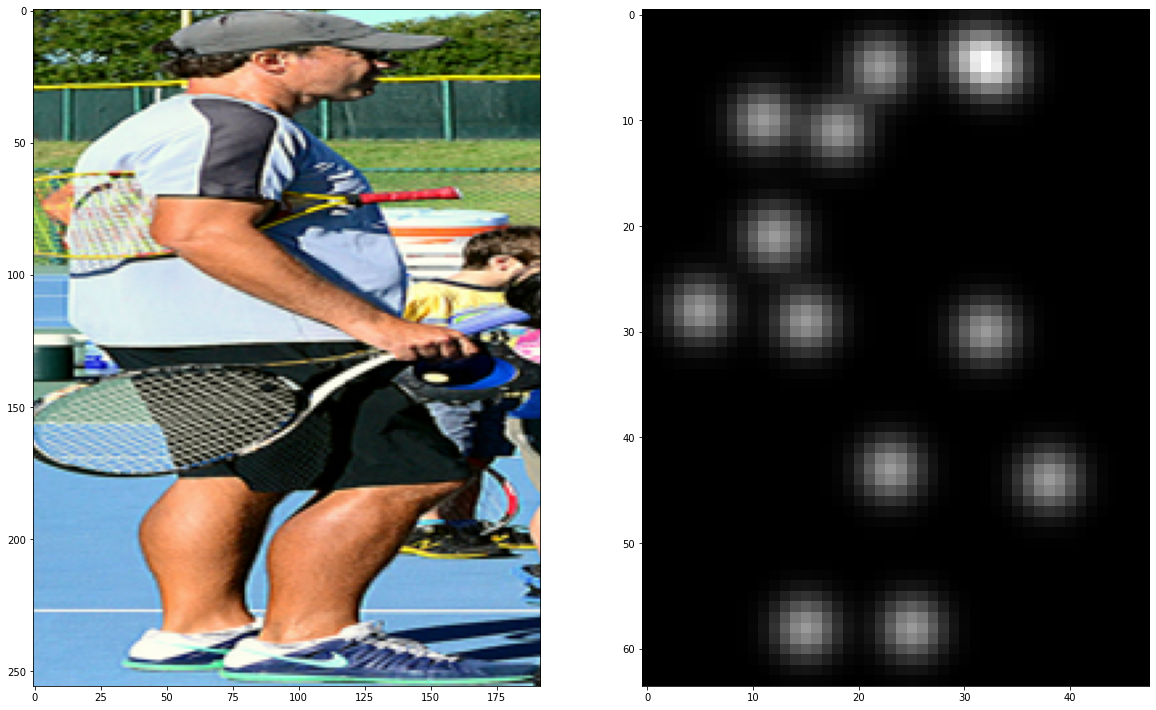

In [ ]:
print("GROUNDTRUTH HEATMAP")
plotting_data(single_cv_img,single_cv_gt_heatmap,single_cv_gt_validity)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PREDICTED HEATMAP


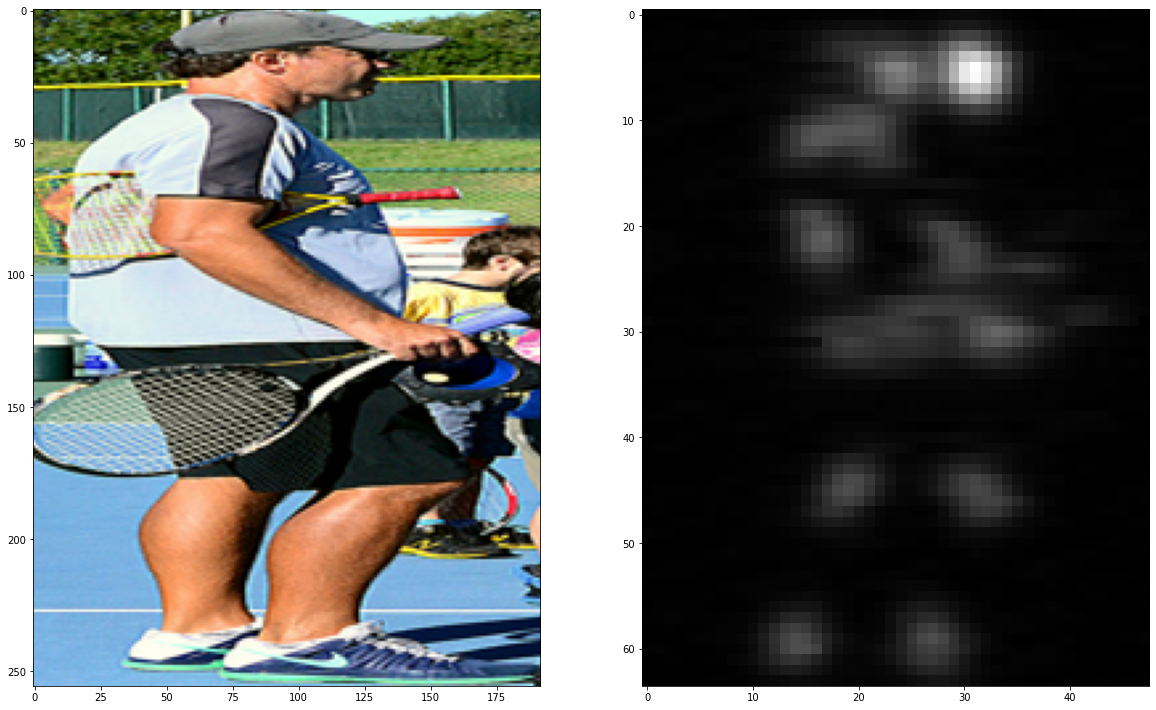

In [ ]:
print("PREDICTED HEATMAP")
plotting_data(single_cv_img,cv_img_heatmap_pred.numpy(),single_cv_gt_validity)

In [ ]:
train_images = os.listdir("/content/drive/MyDrive/Human Pose Estimation/Human Pose Estimation Data/person train images")
train_datagen = train_generator(train_images,training_annotations,batch_size=batch_size)

In [ ]:
train_imgs_batch,train_gt_heatmaps_batch,train_gt_validities_batch = next(train_datagen)
single_train_img = train_imgs_batch[0,:,:,:]
single_train_img = single_train_img.reshape(1,single_train_img.shape[0],single_train_img.shape[1],
                                            single_train_img.shape[2])
single_train_gt_heatmap = train_gt_heatmaps_batch[0,:,:,:]
single_train_gt_heatmap = single_train_gt_heatmap.reshape(1,single_train_gt_heatmap.shape[0],
                                                          single_train_gt_heatmap.shape[1],
                                                          single_train_gt_heatmap.shape[2])
single_train_gt_validity = train_gt_validities_batch[0,:,:,:]
single_train_gt_validity = single_train_gt_validity.reshape(1,single_train_gt_validity.shape[0],
                                                            single_train_gt_validity.shape[1],
                                                            single_train_gt_validity.shape[2])

GROUNDTRUTH HEATMAP


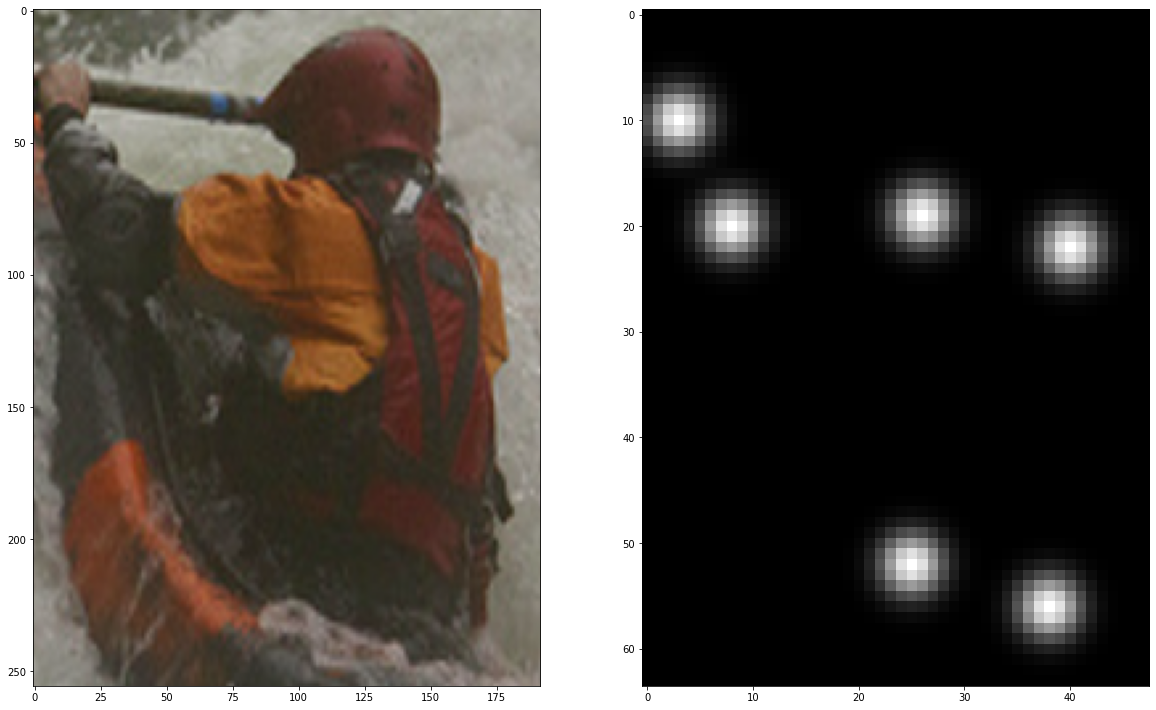

In [ ]:
print("GROUNDTRUTH HEATMAP")
plotting_data(single_train_img,single_train_gt_heatmap,single_train_gt_validity)

In [ ]:
pretrained_pose_resnet.trainable = False
train_img_heatmap_pred = pretrained_pose_resnet(single_train_img,training=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PREDICTED HEATMAP


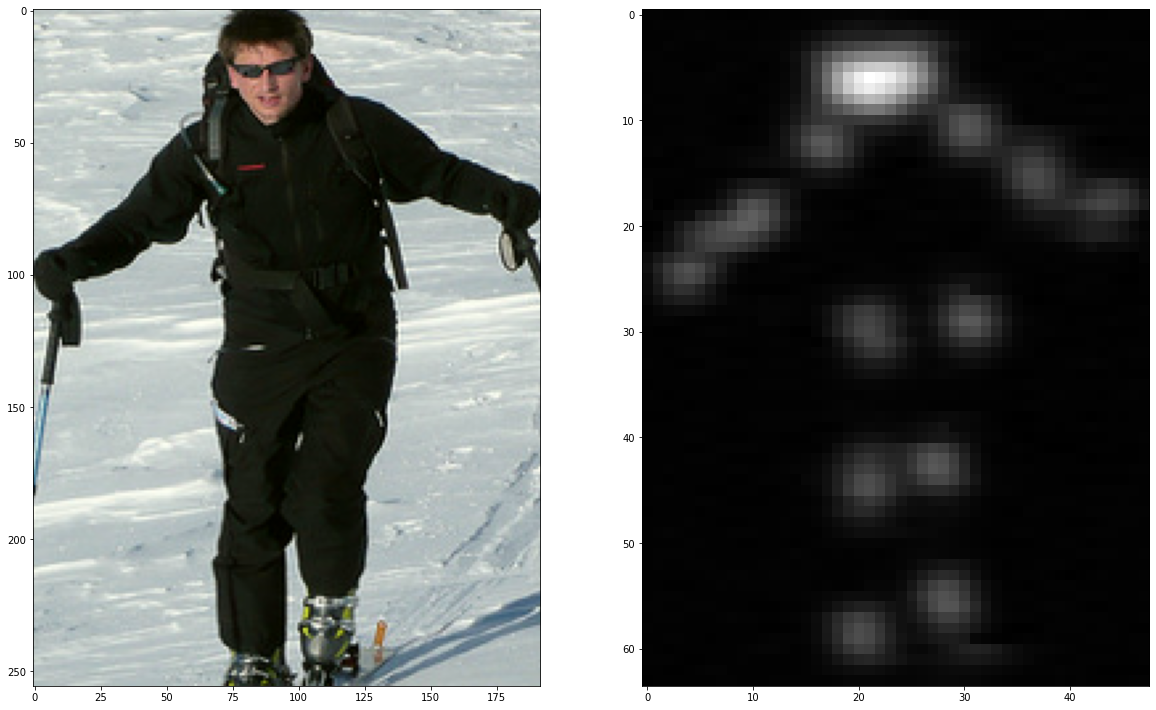

In [ ]:
print("PREDICTED HEATMAP")
plotting_data(single_train_img,train_img_heatmap_pred.numpy(),single_train_gt_validity)